In [1]:
import numpy as np
import scipy.linalg as slin
from matplotlib import pyplot as plt

In [2]:
MAGIC = 1
EPS = 1e-5

### SparseMatrix

In [3]:
class SparseMatrix:
    __array_priority__ = MAGIC
    def __init__(self, arr, size=None):
        if isinstance(arr, tuple):  # SparseMatrix form
            self._rows, self._cols, self._vals = arr
            assert (size != None)
            self.size = size  # (h, w)
        else:
            if not isinstance(arr, np.ndarray):
                arr = np.array(arr)
            rows_cols = np.where(arr != 0)
            self._rows, self._cols = rows_cols
            self._vals = arr[rows_cols]
            self.size = arr.shape

    def __mul__(self, other):
        assert (other.size == self.size[1])
        other.reshape(-1,)
        res_vec = [0] * self.size[0]
        for i, col in enumerate(self._rows):
            res_vec[col] += other[self._cols[i]] * self._vals[i]
        return np.array(res_vec)

    def __rmul__(self, other):
        assert (other.size == self.size[0])
        other.reshape(-1,)
        res_vec = [0] * self.size[1]
        for i, row in enumerate(self._cols):
            res_vec[row] += other[self._rows[i]] * self._vals[i]
        return np.array(res_vec)

### CGD

In [4]:
def conjugate_gradient_method(A, b, x0):
    x = x0
    v = (A * x - b)
    d = v
    v_norm = np.dot(v, v)
    result = [x]
    for i in range(len(b)):
        Ad = A * d
        alpha = v_norm / np.dot(d, Ad)
        x = x - alpha * d
        v = v - alpha * Ad
        v_norm_new = np.dot(v, v)
        d = v + (v_norm_new / v_norm) * d
        v_norm = v_norm_new
        result.append(x)
    return result

### Tests

In [9]:
def test_sparse_matrix_not_sparse():
    np.random.seed(0)
    for _ in range(100):
        [h,w] = np.random.randint(1, 15, size=2)
        A = np.random.rand(h,w)
        b = np.random.rand(h)
        c = np.random.rand(w)
        assert (np.linalg.norm(A @ c - SparseMatrix(A) * c) < EPS)
        assert (np.linalg.norm(b @ A - b * SparseMatrix(A)) < EPS)

def test_sparse_matrix_sparse():
    np.random.seed(0)
    for _ in range(100):
        [h, w] = np.random.randint(25, 100, size=2)
        kol = np.random.randint(1, h * w // 10)
        cols = np.random.randint(w, size=kol)
        rows = np.random.randint(h, size=kol)
        rows, cols = np.unique(np.vstack((rows, cols)), axis=1)  # filter (row1, col1) = (row2, col2)
        vals = np.random.randint(-100, 100, size=rows.size)
        sparseA = SparseMatrix((rows, cols, vals), size=(h, w))
        A = np.zeros((h, w))
        A[rows, cols] = vals
        b = np.random.rand(h)
        c = np.random.rand(w)
        assert (np.linalg.norm(A @ c - sparseA * c) < EPS)
        assert (np.linalg.norm(b @ A - b * sparseA) < EPS)

def test_conjugate_gradient(sz=5):
    A = np.random.rand(sz, sz)
    A = A @ A.T
    sD = slin.sqrtm(np.linalg.inv(np.diag(np.diag(A))))
    A = sD.T @ A @ sD
    A = SparseMatrix(A)
    b = np.random.rand(sz)
    ans = conjugate_gradient_method(A, b, np.zeros_like(b))
    fig, axs = plt.subplots(1, 1, figsize=(10, 7))
    axs.plot([i for i in range(len(ans))], [np.linalg.norm(A * x - b) for x in ans], label='CGD')
    axs.legend()
    axs.set_ylabel(r"$\||Ax_k-b\||$", fontsize=20)
    axs.set_xlabel(r"$k$", fontsize=20)
    axs.set_yscale("log")
    plt.show()

In [6]:
test_sparse_matrix_not_sparse()

In [7]:
test_sparse_matrix_sparse()

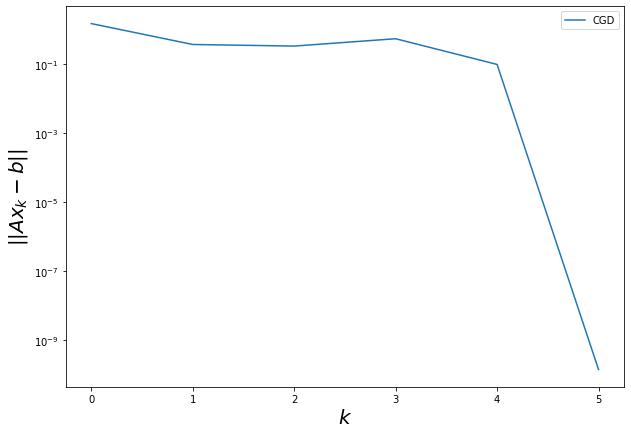

In [10]:
test_conjugate_gradient()